### title: "Bike sharing challenge"
#### author: "Rudger Dame"
#### date: "July 6, 2022"


## Data exploration

In [223]:
import numpy as np 
import pandas as pd 
from sklearn import preprocessing

#### Downloading the provided data

In [224]:
weather = pd.read_csv('weather_data.csv')
trip = pd.read_csv('trip_data.csv')
station = pd.read_csv('station_data.csv')


In [225]:
weather.head(4)

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,01/09/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,02/09/2014,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,03/09/2014,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,04/09/2014,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107


#### Explore the trip and station data

In [226]:
trip.head(4)

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,31/08/2015 23:26,50,31/08/2015 23:39,70,Subscriber
1,913459,31/08/2015 23:11,31,31/08/2015 23:28,27,Subscriber
2,913455,31/08/2015 23:13,47,31/08/2015 23:18,64,Subscriber
3,913454,31/08/2015 23:10,10,31/08/2015 23:17,8,Subscriber


In [227]:
station.head(3)

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose


#### Calculate the duration of the trip in minutes and encode wheither it was a subscriber

In [228]:
trip['Start Date']= pd.to_datetime(trip['Start Date'])
trip['End Date']= pd.to_datetime(trip['End Date'])
trip['Duration'] = (trip['End Date'] - trip['Start Date']).dt.seconds/60 # Duration minutes of the trip

label_encoder = preprocessing.LabelEncoder()
trip["Subscriber Type"] = label_encoder.fit_transform(trip["Subscriber Type"])
trip.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,Duration
0,913460,2015-08-31 23:26:00,50,2015-08-31 23:39:00,70,1,13.0
1,913459,2015-08-31 23:11:00,31,2015-08-31 23:28:00,27,1,17.0
2,913455,2015-08-31 23:13:00,47,2015-08-31 23:18:00,64,1,5.0
3,913454,2015-08-31 23:10:00,10,2015-08-31 23:17:00,8,1,7.0
4,913453,2015-08-31 23:09:00,51,2015-08-31 23:22:00,60,0,13.0


#### Replace city names with zipcode to help join data frames latter on

In [229]:
station.City.replace(to_replace=['San Francisco'],value='94107',inplace=True)
station.City.replace(to_replace=['Redwood City'],value='94063',inplace=True)
station.City.replace(to_replace=['Palo Alto'],value='94301',inplace=True)
station.City.replace(to_replace=['Mountain View'],value='94041',inplace=True)
station.City.replace(to_replace=['San Jose'],value='95113',inplace=True)
station = station.rename(columns={'City': 'Zip'})
station.head()

,Id,Name,Lat,Long,Dock Count,Zip
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,95113
1,3,San Jose Civic Center,37.330698,-121.888979,15,95113
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,95113
3,5,Adobe on Almaden,37.331415,-121.893200,19,95113
4,6,San Pedro Square,37.336721,-121.894074,15,95113


#### Remove major outliers from the data (any trips that is longer than 6 hours). This will remove less than 0.5% of the data.


In [230]:
trip.Duration.describe()

count    354152.000000
mean         15.258844
std          49.935740
min           0.000000
25%           6.000000
50%           9.000000
75%          12.000000
max        1437.000000
Name: Duration, dtype: float64

In [231]:
trip['Duration'].quantile(0.995)
trip = trip[trip.Duration <= 360]

#### From the trip dataset, create two new data frames. One that describes the instance that someone leaves a station and another when there is an end to a trip. The flux feature is created here, -1 for starting and 1 for ending a trip, to later calculate the net flux out of in and out of a station. The two data frames are then appended together. Data from the stations are then joined to this data frame, adding Zipcode and Dock Count.

In [232]:
start = trip[["Trip ID","Start Date","Start Station","Subscriber Type","Duration"]].copy()
start = start.rename(columns={'Start Date': 'Date','Start Station': 'Station'})
start['flux'] = -1

station_copy = station[["Id","Dock Count","Zip"]].copy()
start = pd.merge(start, station_copy, left_on=  ['Station'],
                   right_on= ['Id'], 
                   how = 'left')
start = start.drop(['Id',"Trip ID"], axis=1)

end = trip[["Trip ID","End Date","End Station","Subscriber Type","Duration"]].copy()
end = end.rename(columns={'End Date': 'Date','End Station': 'Station'})
end['flux'] = 1

station_copy = station[["Id","Dock Count","Zip"]].copy()
end = pd.merge(end, station_copy, left_on=  ['Station'],
                   right_on= ['Id'], 
                   how = 'left')
end = end.drop(['Id',"Trip ID"], axis=1)
df = start.append(end, ignore_index=True)
df

,Date,Station,Subscriber Type,Duration,flux,Dock Count,Zip
0,2015-08-31 23:26:00,50,1,13.0,-1,23,94107
1,2015-08-31 23:11:00,31,1,17.0,-1,15,94041
2,2015-08-31 23:13:00,47,1,5.0,-1,19,94107
3,2015-08-31 23:10:00,10,1,7.0,-1,15,95113
4,2015-08-31 23:09:00,51,0,13.0,-1,19,94107
...,...,...,...,...,...,...,...
705727,2014-01-09 04:32:00,65,1,11.0,1,15,94107
705728,2014-01-09 05:08:00,70,0,112.0,1,19,94107
705729,2014-01-09 00:14:00,57,0,9.0,1,15,94107
705730,2014-01-09 00:15:00,57,0,10.0,1,15,94107


In [233]:
df['Day'] = df.Date.dt.date
df['Day'] = pd.to_datetime(df['Day'])

#### Then group the data frame by date in hour intervals and station number. This also averages the subscriber types and trip durations associated with the station.

In [234]:
df_time = df.groupby([pd.Grouper(key='Date',freq='h'), 'Station']).agg(flux=('flux', 'sum'),
                                                       Ave_Sub_Type=('Subscriber Type', 'mean'),
                                                       ave_duration=('Duration', 'mean'),
                                                       Dock_Count=('Dock Count', 'mean'),
                                                       Zip=('Zip', 'median'),
                                                       Day=('Day', 'mean')).reset_index()
df_time.head(10)

,Date,Station,flux,Ave_Sub_Type,ave_duration,Dock_Count,Zip,Day
0,2014-01-09 00:00:00,57,3,0.0,9.666667,15.0,94107.0,2014-01-09
1,2014-01-09 00:00:00,66,-3,0.0,9.666667,19.0,94107.0,2014-01-09
2,2014-01-09 03:00:00,50,-1,0.0,112.000000,23.0,94107.0,2014-01-09
3,2014-01-09 04:00:00,39,-1,1.0,11.000000,19.0,94107.0,2014-01-09
4,2014-01-09 04:00:00,65,1,1.0,11.000000,15.0,94107.0,2014-01-09
5,2014-01-09 04:00:00,66,-1,1.0,4.000000,19.0,94107.0,2014-01-09
6,2014-01-09 05:00:00,68,-1,1.0,6.000000,19.0,94107.0,2014-01-09
7,2014-01-09 05:00:00,70,1,0.0,112.000000,19.0,94107.0,2014-01-09
8,2014-01-09 05:00:00,72,1,1.0,4.000000,23.0,94107.0,2014-01-09
9,2014-01-09 06:00:00,67,-1,1.0,7.000000,27.0,94107.0,2014-01-09


In [235]:
df_time['Dock_Count'] = df_time['Dock_Count'].astype(int)
df_time['Zip'] = df_time['Zip'].astype(int)

#### Begin exploring the weather data

In [236]:
weather.Date = pd.to_datetime(weather.Date)
weather.head(4)

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,2014-01-09,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,2014-02-09,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,2014-03-09,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,2014-04-09,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107


In [237]:
weather.isnull().sum()

Date                            0
Max TemperatureF                4
Mean TemperatureF               4
Min TemperatureF                4
Max Dew PointF                 50
MeanDew PointF                 50
Min DewpointF                  50
Max Humidity                   50
Mean Humidity                  50
Min Humidity                   50
Max Sea Level PressureIn        1
Mean Sea Level PressureIn       1
Min Sea Level PressureIn        1
Max VisibilityMiles             5
Mean VisibilityMiles            5
Min VisibilityMiles             5
Max Wind SpeedMPH               1
Mean Wind SpeedMPH              1
Max Gust SpeedMPH             541
PrecipitationIn                 1
CloudCover                      1
Events                       1538
WindDirDegrees                  1
Zip                             0
dtype: int64

#### All the null values for 'Events' should be interpreted as normal weather days. The wind direction is in degrees, and needs to be converted so it reflects 0 and 360 degrees as the same direction.

In [238]:
weather.loc[weather.Events.isnull(), 'Events'] = "Normal"

events = pd.get_dummies(weather.Events)
weather = weather.merge(events, left_index = True, right_index = True)
weather = weather.drop(['Events',"Max Gust SpeedMPH"],1)
weather['WindDirDegrees'] = [np.sin(i * 2*np.pi) for i in weather['WindDirDegrees'].values]
weather['WindDirDegrees'] = [np.cos(i * 2*np.pi) for i in weather['WindDirDegrees'].values]

/var/folders/7l/_d7_56ts4p92bz2zmh89wzyw0000gn/T/ipykernel_33475/3864062184.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  weather = weather.drop(['Events',"Max Gust SpeedMPH"],1)


#### Fill in the null values with the previous day's value.

In [239]:
weather = weather.ffill()
weather.isnull().sum()

Date                         0
Max TemperatureF             0
Mean TemperatureF            0
Min TemperatureF             0
Max Dew PointF               0
MeanDew PointF               0
Min DewpointF                0
Max Humidity                 0
Mean Humidity                0
Min Humidity                 0
Max Sea Level PressureIn     0
Mean Sea Level PressureIn    0
Min Sea Level PressureIn     0
Max VisibilityMiles          0
Mean VisibilityMiles         0
Min VisibilityMiles          0
Max Wind SpeedMPH            0
Mean Wind SpeedMPH           0
PrecipitationIn              0
CloudCover                   0
WindDirDegrees               0
Zip                          0
Fog                          0
Fog-Rain                     0
Normal                       0
Rain                         0
Rain-Thunderstorm            0
dtype: int64

#### Join the weather data to the trip data

In [240]:
weather = weather.rename(columns={'Date': 'Day'})
df = pd.merge(df_time, weather,  how='left', left_on=['Day','Zip'], right_on = ['Day','Zip'])
df.head(4)

,Date,Station,flux,Ave_Sub_Type,ave_duration,Dock_Count,Zip,Day,Max TemperatureF,Mean TemperatureF,...,Max Wind SpeedMPH,Mean Wind SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,2014-01-09 00:00:00,57,3,0.0,9.666667,15,94107,2014-01-09,83.0,70.0,...,16.0,7.0,0.0,0.0,1.0,0,0,1,0,0
1,2014-01-09 00:00:00,66,-3,0.0,9.666667,19,94107,2014-01-09,83.0,70.0,...,16.0,7.0,0.0,0.0,1.0,0,0,1,0,0
2,2014-01-09 03:00:00,50,-1,0.0,112.000000,23,94107,2014-01-09,83.0,70.0,...,16.0,7.0,0.0,0.0,1.0,0,0,1,0,0
3,2014-01-09 04:00:00,39,-1,1.0,11.000000,19,94107,2014-01-09,83.0,70.0,...,16.0,7.0,0.0,0.0,1.0,0,0,1,0,0


#### Note weither the date is a holiday or a workday

In [241]:
from pandas.tseries.holiday import USFederalHolidayCalendar

# Federal holidays 
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=df.Date.min(), end=df.Date.max())
# Business says
business_days = pd.bdate_range(start=df.Date.min(), end=df.Date.max())

business_days = pd.to_datetime(business_days, format='%Y/%m/%d').date
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date


df['business_day'] = df.Day.isin(business_days)
df['holiday'] = df.Day.isin(holidays)
#Convert True to 1 and False to 0
df.business_day = df.business_day.map(lambda x: 1 if x == True else 0)
df.holiday = df.holiday.map(lambda x: 1 if x == True else 0)
df.head(4)

,Date,Station,flux,Ave_Sub_Type,ave_duration,Dock_Count,Zip,Day,Max TemperatureF,Mean TemperatureF,...,PrecipitationIn,CloudCover,WindDirDegrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm,business_day,holiday
0,2014-01-09 00:00:00,57,3,0.0,9.666667,15,94107,2014-01-09,83.0,70.0,...,0.0,0.0,1.0,0,0,1,0,0,1,0
1,2014-01-09 00:00:00,66,-3,0.0,9.666667,19,94107,2014-01-09,83.0,70.0,...,0.0,0.0,1.0,0,0,1,0,0,1,0
2,2014-01-09 03:00:00,50,-1,0.0,112.000000,23,94107,2014-01-09,83.0,70.0,...,0.0,0.0,1.0,0,0,1,0,0,1,0
3,2014-01-09 04:00:00,39,-1,1.0,11.000000,19,94107,2014-01-09,83.0,70.0,...,0.0,0.0,1.0,0,0,1,0,0,1,0


#### Convert date to the important features, year, month, day, hour, and weekday (0 = Monday, 1 = Tuesday...)

In [242]:
df['year'] = pd.to_datetime(df['Date']).dt.year
df['month'] = pd.to_datetime(df['Date']).dt.month
df['day'] = pd.to_datetime(df['Date']).dt.day
df['hour'] = pd.to_datetime(df['Date']).dt.hour
df['weekday'] = pd.to_datetime(df['Date']).dt.weekday
df = df.drop(['Day','Zip','Date'], axis=1)
df.head(4)

,Station,flux,Ave_Sub_Type,ave_duration,Dock_Count,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,...,Normal,Rain,Rain-Thunderstorm,business_day,holiday,year,month,day,hour,weekday
0,57,3,0.0,9.666667,15,83.0,70.0,57.0,58.0,56.0,...,1,0,0,1,0,2014,1,9,0,3
1,66,-3,0.0,9.666667,19,83.0,70.0,57.0,58.0,56.0,...,1,0,0,1,0,2014,1,9,0,3
2,50,-1,0.0,112.000000,23,83.0,70.0,57.0,58.0,56.0,...,1,0,0,1,0,2014,1,9,3,3
3,39,-1,1.0,11.000000,19,83.0,70.0,57.0,58.0,56.0,...,1,0,0,1,0,2014,1,9,4,3


#### Visualize the correlation between features.

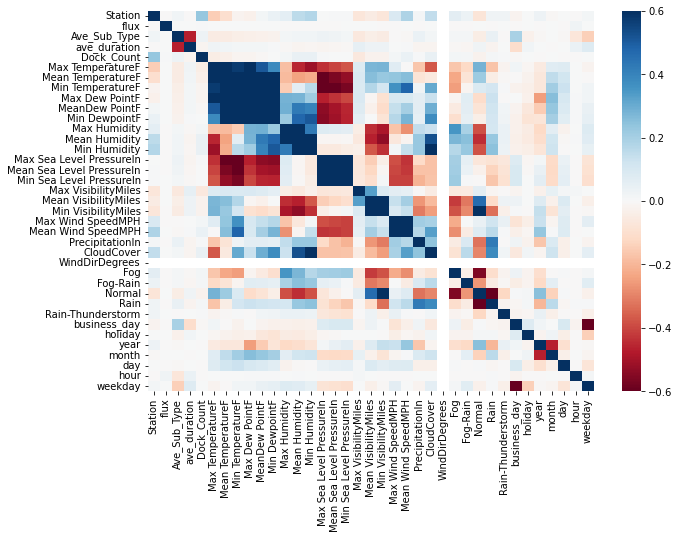

In [253]:
import seaborn as sb
from matplotlib import pyplot as plt
plt.figure(figsize = (10,7))
corr = df.corr()
sb.heatmap(corr, cmap = 'RdBu', vmin=-.6, vmax=.6)
plt.show(sb)

#### A histogram of the net flux per hour. The range of observable fluxes out of stations range between ~-15 and 15 bikes/hr, while peaking at -2 and 2 bikes/hr. 

(-20.0, 20.0)

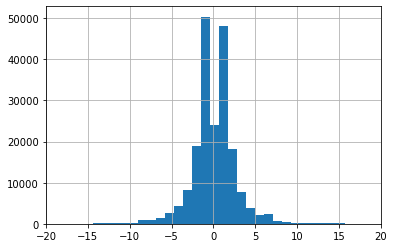

In [244]:
df.flux.hist(bins=80)
plt.xlim(-20,20)

#### Scale and split data

In [245]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
X = df.copy()
X = X.drop(['flux'], axis=1)
X_new = X.copy()

from sklearn.preprocessing import StandardScaler
rc = RobustScaler()
X = rc.fit_transform(X.astype(float))
X

X_train, X_test, y_train, y_test = train_test_split(X, df['flux'], test_size = 0.33, random_state = 0 )

### Modelling approach

In [246]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

#### First explore a simple linear model. This can likely be improved upon.

In [247]:
lr = LinearRegression().fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print('lr train RMSE %.3f, lr test RMSE: %.3f' % (
mean_squared_error(y_train, y_train_pred, squared=False),
mean_squared_error(y_test, y_test_pred, squared=False)))

lr train RMSE 2.907, lr test RMSE: 2.937


#### Random Forest Regression

In [248]:
forest = RandomForestRegressor(n_estimators=100,
                     max_depth=20,
                     min_samples_split=2,
                     min_samples_leaf= 1,
                     bootstrap=True,
                     oob_score=False)
#fit model
forest.fit(X_train,y_train.values.ravel())
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

#print score
print('forest train RMSE %.3f, forest test RMSE: %.3f' % (
mean_squared_error(y_train, y_train_pred, squared=False),
mean_squared_error(y_test, y_test_pred, squared=False)))

forest train RMSE 1.052, forest test RMSE: 2.019


#### Random Forest Regression's feature importances. The hour, Station, the average ride duration in and out of that station, and weither the rider was a subscriber or not seem to be some of the most important features for this model.

In [249]:
importance = pd.DataFrame({"Importance":forest.feature_importances_, "name": list(X_new.columns)}).sort_values("Importance", ascending=False)
importance.head(10)

,Importance,name
34,0.228584,hour
0,0.219377,Station
2,0.105425,ave_duration
1,0.060763,Ave_Sub_Type
3,0.050465,Dock_Count
33,0.027176,day
35,0.022756,weekday
19,0.018458,Max Wind SpeedMPH
4,0.017877,Max TemperatureF
32,0.017657,month


### Performance analysis

#### Filter down the test data to display how the RMSE varies for different sizes of Net flux (bikes/hr), monthly, and hourly. The following plots show important strengths and weaknesses in the model.

- The Net flux was very low or very high our model performed poorly because of the small sample size in those regions. 
- The RMSE did't vary significantly over different months.
- THe RMSE seemed to peak at hours between 8-10 am and 5-7 pm

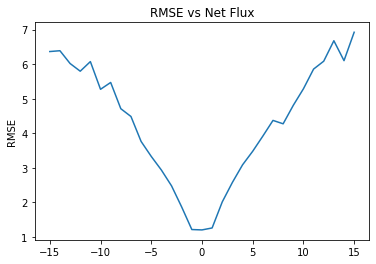

In [250]:
from matplotlib import pyplot as plt
flux_rmse_list = []
for flux_val in range(-15,16):
    temp_df = X_test[y_test.values==flux_val]
    preds = forest.predict(temp_df)
    flux_rmse_list += [mean_squared_error(y_test[y_test==flux_val], preds, squared=False)]
x = range(-15,16)
plt.plot(x, flux_rmse_list)
plt.ylabel('RMSE')
plt.title('RMSE vs Net Flux')
plt.show()

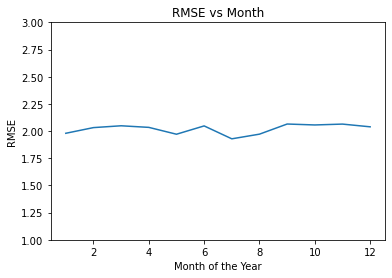

In [251]:
months = list(set(X_test[:,list(X_new.columns).index("month")]))
months.sort()
month_rmse_list = []
for month in months:
    temp_df = X_test[X_test[:,list(X_new.columns).index("month")]==month]
    preds = forest.predict(temp_df)
    month_rmse_list += [mean_squared_error(y_test[X_test[:,list(X_new.columns).index("month")]==month], preds, squared=False)]
x = range(1,13)
plt.plot(x, month_rmse_list)
plt.ylabel('RMSE')
plt.xlabel('Month of the Year')
plt.title('RMSE vs Month')
plt.ylim([1, 3])
plt.show()

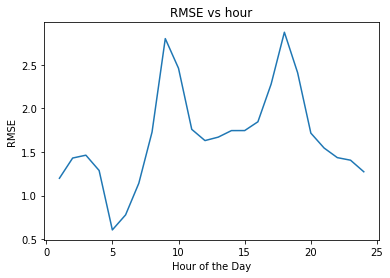

In [252]:
hours = list(set(X_test[:,list(X_new.columns).index("hour")]))
hours.sort()
hour_rmse_list = []
for hour in hours:
    temp_df = X_test[X_test[:,list(X_new.columns).index("hour")]==hour]
    preds = forest.predict(temp_df)
    hour_rmse_list += [mean_squared_error(y_test[X_test[:,list(X_new.columns).index("hour")]==hour], preds, squared=False)]
x = range(1,25)
plt.plot(x, hour_rmse_list)
plt.ylabel('RMSE')
plt.xlabel('Hour of the Day')
plt.title('RMSE vs hour')
plt.show()
    

### Conclusions

In conclusion, the Random Forest Regression model performed best with an RMSE of ~2 bikes/hr. This is significant with the spread of the net flux per hour to range mostly from -15 to 15 bikes/hr.  The model performs best at times of lower flux and non-commuting hours. Month of the year doesn't seems to play a large part in the model but this datset is only over the course ~ 1 year.  

### Potential improvements

Potential improvements to this model are many. Because of time and computing capabilities, I was'nt able to perform cross validation or a grid search to improve the analysis and model. With more time, I would have done more feature engineering and explore unique features. One feature worth looking into would be the average distance traveled to and from each station. An additional way to potentially improve the model would be to train the subscriber and and non-subscriber data seperately and add them together to see if that better catches outling data points. Analyze the network of stations and look for common routes and patterns might be the source of additional feautres. 